# Machine Learning Methods

This section applies supervised ML models to the employability dataset.  
We evaluate baseline, linear, and ensemble methods, and compare performance.


## Loading the Dataset and Initial Inspection

In [53]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor



In [54]:
# Step 1 — Load Dataset and Initial Inspection
import pandas as pd
df = pd.read_csv("data/data_science_job_posts_2025.csv")
df.columns


Index(['job_title', 'seniority_level', 'status', 'company', 'location',
       'post_date', 'headquarter', 'industry', 'ownership', 'company_size',
       'revenue', 'salary', 'skills'],
      dtype='object')

In [55]:
df.info()
df.isna().mean().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        941 non-null    object
 1   seniority_level  884 non-null    object
 2   status           688 non-null    object
 3   company          944 non-null    object
 4   location         942 non-null    object
 5   post_date        944 non-null    object
 6   headquarter      944 non-null    object
 7   industry         944 non-null    object
 8   ownership        897 non-null    object
 9   company_size     944 non-null    object
 10  revenue          929 non-null    object
 11  salary           944 non-null    object
 12  skills           944 non-null    object
dtypes: object(13)
memory usage: 96.0+ KB


status             0.271186
seniority_level    0.063559
ownership          0.049788
revenue            0.015890
job_title          0.003178
location           0.002119
company            0.000000
headquarter        0.000000
post_date          0.000000
industry           0.000000
company_size       0.000000
salary             0.000000
skills             0.000000
dtype: float64

In [56]:
df.head(10)

,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
0,data scientist,senior,hybrid,company_003,"Grapevine, TX . Hybrid",17 days ago,"Bentonville, AR, US",Retail,Public,€352.44B,Public,"€100,472 - €200,938","['spark', 'r', 'python', 'scala', 'machine lea..."
1,data scientist,lead,hybrid,company_005,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030",€51.10B,"€118,733","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,company_007,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930",€33.80B,"€94,987 - €159,559","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,company_008,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690",€81.71B,"€112,797 - €194,402","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,company_009,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"€114,172 - €228,337",[]
5,data scientist,lead,NaN,company_013,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,€2.16B,"€196,371 - €251,170","['scikit-learn', 'python', 'scala', 'sql', 'ma..."
6,data scientist,junior,NaN,company_014,"Berkeley, CA",15 days ago,"Berkeley, CA, US",Education,NaN,"17,471",Education,"€51,330 - €70,144",[]
7,machine learning engineer,senior,on-site,company_015,"Menlo Park, CA",9 days ago,"Menlo Park, CA, US",Technology,Public,900,Public,"€121,480 - €132,440",['machine learning']
8,data scientist,senior,remote,company_019,Fully Remote,6 days ago,"Boston, MA, US",Technology,Private,126,Private,"€207,331",[]
9,data scientist,senior,on-site,company_021,On-site,a day ago,"San Francisco, CA, US",Technology,Public,"5,520",€61.06B,"€219,201",[]


In [57]:
# Step 2 – Create binary skill features (python, sql, spark, etc.)

skill_keywords = [
    "python", "sql", "spark", "r", "scala", "docker",
    "tableau", "powerbi",
    "tensorflow", "pytorch", "machine learning", "deep learning",
    "aws", "azure", "gcp"
]

for kw in skill_keywords:
    col = "skill_" + kw.lower().replace(" ", "_")
    df[col] = df["skills"].str.contains(kw, case=False, na=False).astype(int)



In [58]:
# Check how many postings mention each skill

df.filter(like="skill_").sum()

skill_python              640
skill_sql                 442
skill_spark               161
skill_r                   694
skill_scala                85
skill_docker               54
skill_tableau             116
skill_powerbi              25
skill_tensorflow          165
skill_pytorch             148
skill_machine_learning    580
skill_deep_learning       178
skill_aws                 218
skill_azure               155
skill_gcp                 106
dtype: int64

In [59]:
# Step 3 — Create Binary Target: Is This an ML Role?

ml_keywords = [
    "machine learning", "deep learning", "neural network",
    "tensorflow", "pytorch", "ai", "ml"
]

pattern = "|".join(ml_keywords)

df["is_ml_role"] = df["skills"].str.contains(pattern, case=False, na=False).astype(int)

df["is_ml_role"].value_counts()


is_ml_role
1    603
0    341
Name: count, dtype: int64

In [60]:
# Step 4 – Clean salary column

import re

def parse_salary_range(s):
    if pd.isna(s):
        return (None, None)
    
    # Remove € and commas
    s = s.replace("€", "").replace(",", "").strip()
    
    # Match patterns like "100000 – 200000"
    match = re.findall(r"(\d+)", s)
    
    if len(match) == 2:
        low, high = map(int, match)
        return low, high
    else:
        return (None, None)

# Apply to dataset
df["salary_min"], df["salary_max"] = zip(*df["salary"].apply(parse_salary_range))

# Average salary
df["salary_avg"] = df[["salary_min", "salary_max"]].mean(axis=1)

df[["salary_min", "salary_max", "salary_avg"]].head()


,salary_min,salary_max,salary_avg
0,100472.0,200938.0,150705.0
1,NaN,NaN,NaN
2,94987.0,159559.0,127273.0
3,112797.0,194402.0,153599.5
4,114172.0,228337.0,171254.5


In [61]:
# Check missing salary values
df[["salary_min", "salary_max", "salary_avg"]].isna().sum()


salary_min    350
salary_max    350
salary_avg    350
dtype: int64

The dataset contained missing values across several fields such as seniority_level, status, salary, revenue, and ownership. Missing salary values were particularly common because many job postings did not disclose salary ranges. After transforming the salary column into numeric values (min, max, avg), these missing entries became explicit as NaN

In [62]:
df["seniority_level"].value_counts(dropna=False)
df["status"].value_counts(dropna=False)
df["industry"].value_counts().head(20)


industry
Technology       582
Finance          127
Retail           110
Healthcare        83
Education         19
Energy            12
Manufacturing      7
Logistics          4
Name: count, dtype: int64

# Step 5 — Encode Categorical Features for ML Models

In [63]:
df["seniority_level"].value_counts(dropna=False)


seniority_level
senior      630
lead        116
midlevel    113
NaN          60
junior       25
Name: count, dtype: int64

In [64]:
# Step 5A – Encode seniority_level

# Fill missing with "unknown"
df["seniority_level"] = df["seniority_level"].fillna("unknown")

# Ensure lowercase
df["seniority_level"] = df["seniority_level"].str.lower()

# One-hot encode
seniority_dummies = pd.get_dummies(df["seniority_level"], prefix="seniority")

# Add to dataframe
df = pd.concat([df, seniority_dummies], axis=1)

df[seniority_dummies.columns].head()


,seniority_junior,seniority_lead,seniority_midlevel,seniority_senior,seniority_unknown
0,False,False,False,True,False
1,False,True,False,False,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,False,True


## STEP 5B – Encode status (remote / hybrid / on-site)

In [65]:
df["status"].value_counts(dropna=False)


status
on-site    363
NaN        256
hybrid     207
remote     118
Name: count, dtype: int64

In [66]:

# Replace missing with "unknown"
df["status"] = df["status"].fillna("unknown").str.lower()

status_dummies = pd.get_dummies(df["status"], prefix="status")

df = pd.concat([df, status_dummies], axis=1)

df[status_dummies.columns].head()


,status_hybrid,status_on-site,status_remote,status_unknown
0,True,False,False,False
1,True,False,False,False
2,False,True,False,False
3,True,False,False,False
4,False,True,False,False


In [67]:
df[status_dummies.columns].sum()


status_hybrid     207
status_on-site    363
status_remote     118
status_unknown    256
dtype: int64

## STEP 5C — Encode Industry

In [68]:
# Step 5C – One-hot encode industry

df["industry"] = df["industry"].str.lower()

industry_dummies = pd.get_dummies(df["industry"], prefix="industry")

df = pd.concat([df, industry_dummies], axis=1)

df[industry_dummies.columns].head()


,industry_education,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False


In [69]:
industry_dummies.sum()


industry_education         19
industry_energy            12
industry_finance          127
industry_healthcare        83
industry_logistics          4
industry_manufacturing      7
industry_retail           110
industry_technology       582
dtype: int64

## Step 6 – Build feature matrix X for clustering and regression

In [70]:
## Step 6 – Build feature matrix X for clustering and regression

# 1) Skill features
skill_cols = [c for c in df.columns if c.startswith("skill_")]

# 2) Seniority dummies
seniority_cols = [
    c for c in df.columns
    if c.startswith("seniority_") and c != "seniority_level"
]

# 3) Status dummies
status_cols = [c for c in df.columns if c.startswith("status_")]

# 4) Industry dummies
industry_cols = [c for c in df.columns if c.startswith("industry_")]

# Combine all features
feature_cols = skill_cols + seniority_cols + status_cols + industry_cols

X = df[feature_cols]

X.dtypes.head(), X.shape


(skill_python    int64
 skill_sql       int64
 skill_spark     int64
 skill_r         int64
 skill_scala     int64
 dtype: object,
 (944, 32))

## Step 7 – Unsupervised Learning: K-Means Clustering


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(944, 32)

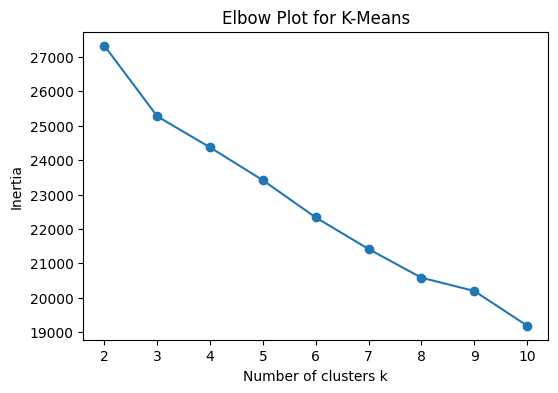

In [72]:
#Elbow plot to determine optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Plot for K-Means")
plt.show()


We selected k = 5 because the reduction in inertia begins to slow after five clusters. While the elbow is not very sharp, k = 5 marks the point where additional clusters provide smaller incremental improvements, making it a reasonable balance between simplicity and segmentation quality.

In [73]:
#Fit K-means with chosen k

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()


cluster
2    229
1    218
4    218
0    166
3    113
Name: count, dtype: int64

Although the inertia curve suggested both 4 and 5 as reasonable options, the 5-cluster solution produced a very small cluster (7 observations), which limits interpretability. Therefore, we selected k = 4, ensuring all clusters are large, stable, and meaningful for analysis.

In [74]:
#Fit K-means with  chosen k=4

k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()


cluster
1    309
2    236
3    228
0    171
Name: count, dtype: int64

In [75]:
#Inspect Cluster Centers (Interpretation)
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X.columns
)
cluster_centers


,skill_python,skill_sql,skill_spark,skill_r,skill_scala,skill_docker,skill_tableau,skill_powerbi,skill_tensorflow,skill_pytorch,...,status_remote,status_unknown,industry_education,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
0,0.463923,-0.094527,0.479443,0.600192,0.298335,0.760944,-0.124916,-0.019252,1.772486,1.836619,...,-0.130409,0.139790,-0.101678,-0.009069,0.051324,-0.021373,2.048539e-01,-0.086433,0.001352,-0.005122
1,0.495273,0.501466,0.166063,0.578189,0.284649,-0.162708,0.158013,0.117237,-0.323888,-0.395593,...,-0.094185,-0.544479,-0.051142,-0.084583,0.032522,-0.001925,-6.523281e-02,0.064455,0.433649,-0.276256
2,-1.287720,-0.827945,-0.453453,-1.598912,-0.314567,-0.246321,-0.296855,-0.164935,-0.460228,-0.431196,...,0.339527,-0.428902,-0.082975,0.037823,-0.071403,-0.071074,9.067605e-17,0.012348,-0.257523,0.274508
3,0.313737,0.248272,-0.115278,0.421272,-0.283922,-0.095231,0.186808,0.026274,-0.414034,-0.395007,...,-0.125988,1.077021,0.231455,0.082283,-0.008660,0.092206,-6.523281e-02,-0.035310,-0.322164,0.094102


In [76]:
#lets make a table 
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X.columns,
    index=[f"cluster_{i}" for i in range(k)]
)

cluster_centers.style.background_gradient(
    cmap="coolwarm"  # red = high, blue = low
)


,skill_python,skill_sql,skill_spark,skill_r,skill_scala,skill_docker,skill_tableau,skill_powerbi,skill_tensorflow,skill_pytorch,skill_machine_learning,skill_deep_learning,skill_aws,skill_azure,skill_gcp,seniority_junior,seniority_lead,seniority_midlevel,seniority_senior,seniority_unknown,status_hybrid,status_on-site,status_remote,status_unknown,industry_education,industry_energy,industry_finance,industry_healthcare,industry_logistics,industry_manufacturing,industry_retail,industry_technology
cluster_0,0.463923,-0.094527,0.479443,0.600192,0.298335,0.760944,-0.124916,-0.019252,1.772486,1.836619,0.623998,1.147535,0.687033,0.772292,0.792742,0.090010,0.017586,-0.206620,0.234329,-0.260525,0.091914,-0.117267,-0.130409,0.139790,-0.101678,-0.009069,0.051324,-0.021373,0.204854,-0.086433,0.001352,-0.005122
cluster_1,0.495273,0.501466,0.166063,0.578189,0.284649,-0.162708,0.158013,0.117237,-0.323888,-0.395593,0.419866,-0.101473,0.051005,-0.058847,-0.140399,-0.124625,0.079153,-0.229183,0.280120,-0.260525,-0.013746,0.573289,-0.094185,-0.544479,-0.051142,-0.084583,0.032522,-0.001925,-0.065233,0.064455,0.433649,-0.276256
cluster_2,-1.287720,-0.827945,-0.453453,-1.598912,-0.314567,-0.246321,-0.296855,-0.164935,-0.460228,-0.431196,-1.236186,-0.482054,-0.487647,-0.431790,-0.328815,-0.112156,-0.025813,-0.264329,-0.166378,0.781575,0.320030,-0.111053,0.339527,-0.428902,-0.082975,0.037823,-0.071403,-0.071074,0.000000,0.012348,-0.257523,0.274508
cluster_3,0.313737,0.248272,-0.115278,0.421272,-0.283922,-0.095231,0.186808,0.026274,-0.414034,-0.395007,0.242533,-0.224160,-0.079643,-0.052525,-0.063926,0.217482,-0.093744,0.739172,-0.383167,-0.260525,-0.381566,-0.574058,-0.125988,1.077021,0.231455,0.082283,-0.008660,0.092206,-0.065233,-0.035310,-0.322164,0.094102


**Cluster 0**: represents **Machine Learning Engineers/AI Engineers**, characterized by the strongest deep learning stack (TensorFlow, PyTorch, ML, DL), the broadest cloud expertise (AWS/Azure/GCP), and robust programming (Python, R, Docker). They are more common in logistics and rarely appear in manufacturing, and they tend to work in hybrid settings rather than fully on-site roles.

**Cluster 1** represents senior **Data Engineering and Analytics Engineering** roles. These jobs show the highest proficiency in Python, SQL, Spark, Scala, and Tableau, and appear predominantly in finance, healthcare, manufacturing, and retail. The strong presence of lead-level roles and on-site work further indicates a traditional enterprise engineering environment rather than modern remote ML roles.

 **Cluster 2** consists of low-information or non-technical data roles. These job postings show the lowest levels of programming, analytics, cloud, and machine learning skills across all clusters. They also contain the highest proportion of unknown seniority and are most frequently remote or hybrid. The absence of clear technical requirements and the inconsistent industry pattern suggest that these positions are general data-related or support roles rather than specialized data engineering, analytics, or machine learning positions.


   **Cluster 3** represents **mid-level generalist data roles**, including **Data Analysts and Data Scientists** who work across education, energy, and technology sectors. These jobs show strong Python, SQL, and Tableau usage, moderate R, and only limited machine learning depth. The seniority pattern is centered on mid-level positions, indicating roles that require solid technical competence without the advanced ML or engineering specialization seen in Clusters 0 and 1.

**The purpose of K-means clustering is to uncover natural job families based on shared skill profiles, seniority, and industry characteristics. By grouping similar postings together without using salary, we can identify distinct job types and then compare their compensation and skill requirements in subsequent analysis.**

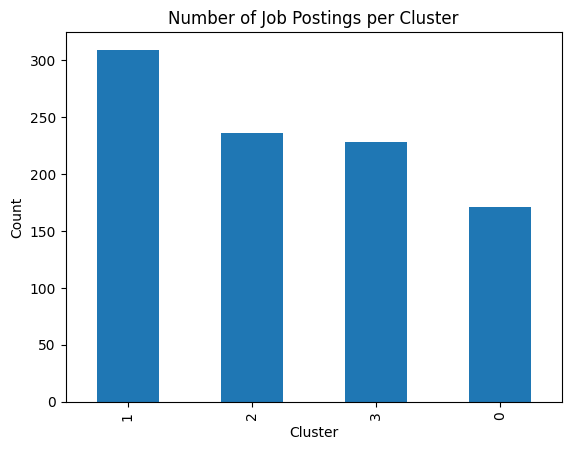

In [77]:
df["cluster"].value_counts().plot(kind="bar")
plt.title("Number of Job Postings per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


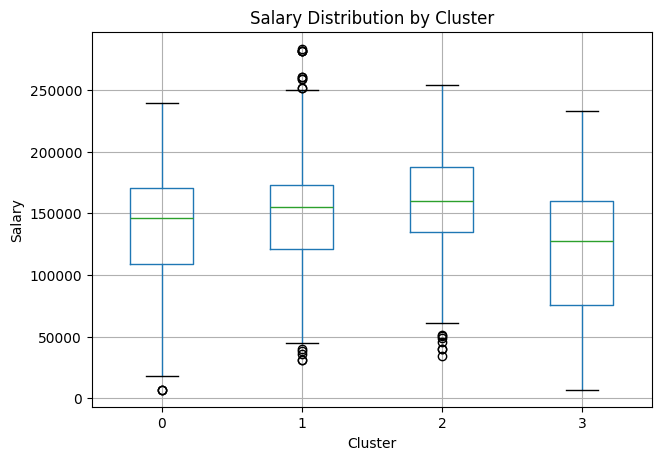

In [78]:
df.boxplot(column="salary_avg", by="cluster", figsize=(7,5))
plt.title("Salary Distribution by Cluster")
plt.suptitle("")
plt.xlabel("Cluster")
plt.ylabel("Salary")
plt.show()


## Supervised Regression Modeling for Salary Prediction

In [103]:
# ===== Block 1 – Clean skill columns =====

# 1) Define the *valid* skills you actually care about
skill_keywords = [
    "python", "sql", "spark", "r", "scala", "docker",
    "excel", "tableau", "power bi",
    "tensorflow", "pytorch", "machine learning", "deep learning",
    "aws", "azure", "gcp"
]

valid_skill_cols = [
    "skill_" + kw.lower().replace(" ", "_") for kw in skill_keywords
]

# 2) Find ALL columns that start with "skill_"
all_skill_cols = [c for c in df.columns if c.startswith("skill_")]

# 3) Anything that starts with "skill_" but is not in our valid list is garbage
extra_skill_cols = [c for c in all_skill_cols if c not in valid_skill_cols]

print("Extra / invalid skill columns to drop:")
print(extra_skill_cols)

# 4) Drop the garbage columns
df = df.drop(columns=extra_skill_cols)


Extra / invalid skill columns to drop:
['skill_powerbi']


In [105]:
# ===== Block 2 – Build X and y for salary regression (robust) =====

# Make sure salary_avg exists and is numeric
df["salary_avg"] = df["salary_avg"].astype(float)

# Drop rows with missing salary
reg_df = df.dropna(subset=["salary_avg"]).copy()

# Skills (already cleaned)
skill_cols = valid_skill_cols

# Seniority / status / industry dummies
seniority_cols = [c for c in reg_df.columns 
                  if c.startswith("seniority_") and c != "seniority_level"]
status_cols    = [c for c in reg_df.columns if c.startswith("status_")]
industry_cols  = [c for c in reg_df.columns if c.startswith("industry_")]

# All desired features
feature_cols = skill_cols + seniority_cols + status_cols + industry_cols

# Keep only columns that actually exist in reg_df
available_features = [c for c in feature_cols if c in reg_df.columns]
missing_features   = sorted(set(feature_cols) - set(available_features))

print("Number of desired features:", len(feature_cols))
print("Number of available features:", len(available_features))

if missing_features:
    print("\nThese expected features were NOT found in reg_df and will be ignored:")
    for c in missing_features:
        print("  -", c)

# Build X and y
X = reg_df[available_features].astype(float)
y = reg_df["salary_avg"].astype(float)


Number of desired features: 33
Number of available features: 31

These expected features were NOT found in reg_df and will be ignored:
  - skill_excel
  - skill_power_bi


In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((415, 31), (179, 31), (415,), (179,))

In [107]:
import statsmodels.api as sm
import numpy as np

# 1. Make sure X_train is purely numeric (float)
X_train_sm = X_train.astype(float)

# 2. Add intercept term
X_train_sm = sm.add_constant(X_train_sm)

# 3. Ensure y is numeric 1-D array
y_train_sm = y_train.astype(float)

# 4. Fit OLS model
ols_model = sm.OLS(y_train_sm, X_train_sm).fit()

# 5. Show R-style summary: coefficients, p-values, R², etc.
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:             salary_avg   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     8.011
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           1.31e-24
Time:                        05:37:13   Log-Likelihood:                -5019.9
No. Observations:                 415   AIC:                         1.010e+04
Df Residuals:                     386   BIC:                         1.021e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   9.45

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ---------- Multiple Linear Regression ----------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

lin_r2 = r2_score(y_test, y_pred_lin)
lin_mse = mean_squared_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(lin_mse)

print("=== Multiple Linear Regression ===")
print(f"R²:   {lin_r2:.3f}")
print(f"RMSE: {lin_rmse:,.0f}")

# ---------- Random Forest Regression ----------
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)

print("\n=== Random Forest Regression ===")
print(f"R²:   {rf_r2:.3f}")
print(f"RMSE: {rf_rmse:,.0f}")


=== Multiple Linear Regression ===
R²:   0.010
RMSE: 57,183

=== Random Forest Regression ===
R²:   0.210
RMSE: 51,108
